In [1]:
from legacy.possession import *
from sklearn.externals import joblib
import numpy as np
import pandas as pd
import glob
import tqdm
from collections import Counter, namedtuple
import seaborn as sns
from legacy.code_mapping import gid2name, code2team
from lib.utils import get_traj_locations
from lib.process_possession import cutOnce
%matplotlib inline

## episode to flat input function

In [4]:
p = joblib.load('Possession(2017012001, 1v4, 603.5-558.9, q2, Field Goal Missed, p0).pkl')

In [5]:
file_name = 'Possession(2017012001, 1v4, 603.5-558.9, q2, Field Goal Missed, p0).pkl'

In [6]:
3>2 and 0<1 and 5>3

True

In [7]:
if 1>2 and 2<1 and 1>3:
    print(1)

In [8]:
eval(file_name.split(',')[2])

44.60000000000002

In [9]:
p.gamecode

2017012001

In [10]:
p.points

0

In [11]:
p1, p2 = cutOnce(p, second=1, crop_len=2)

In [12]:
len(p1.frames), len(p2.frames)

(50, 25)

In [23]:
def episode2flat(episode):

    # traj = namedtuple('Trajectory', ['xp', 'yp', 'xb', 'yb', 'zb'])
    xp = []
    yp = []
    xb = []
    yb = []
    zb = []
    for frame in p1.frames:
        for player in frame.players:
            xp.append(player.x)
            yp.append(player.y)

        xb.append(frame.ball.x)
        yb.append(frame.ball.y)
        zb.append(frame.ball.z)

    xp, yp, xb, yb, zb = np.array(xp), np.array(yp), np.array(xb), np.array(yb), np.array(zb)

    xp = xp.reshape(-1,10)
    yp = yp.reshape(-1,10)
    xb = xb.reshape(-1,1)
    yb = yb.reshape(-1,1)
    zb = zb.reshape(-1,1)

    return np.hstack((xp, yp, xb, yb, zb)).reshape(-1)

In [24]:
traj = episode2flat(p1)

## Shortest trajectory

Because each trajectory has different length, we cannot directly use the whole trajectory. One possible workaround is to use the length equal to the shortest length - 1 second (because we do not use the last second for prediction). Thus, we need to measure the shortest length among all trajectories.

Another possibility is to use a fixed length, such as 3 seconds or so.

In [16]:
traj_locations = get_traj_locations('traj_data/')
len(traj_locations)

763119

In [18]:
from joblib import Parallel, delayed
import multiprocessing

In [28]:
def getLength(file):
    p = joblib.load(file)
    return len(p.frames)

In [34]:
results = Parallel(n_jobs=20)(delayed(getLength)(i) for i in tqdm.tqdm_notebook(traj_locations))

HBox(children=(IntProgress(value=0, max=763119), HTML(value='')))

In [1]:
p.gamecode

NameError: name 'p' is not defined

In [36]:
results = np.array(results)

In [38]:
np.save('./stats/num_frames.npy', results)

In [43]:
results.min()

25

In [44]:
import seaborn as sns

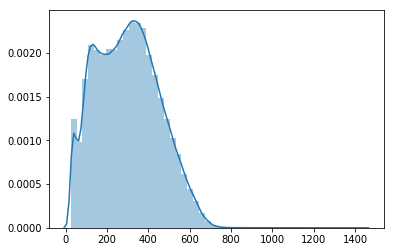

In [48]:
sns.distplot(results)

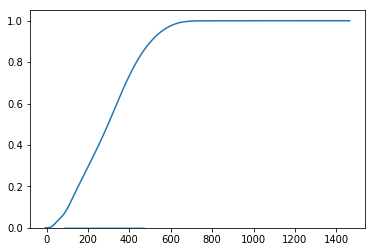

In [62]:
sns.distplot(results, kde_kws=dict(cumulative=True))

In [49]:
import pandas as pd

In [55]:
res = pd.Series(results)

In [56]:
res.describe()

count    763119.000000
mean        299.554625
std         150.120474
min          25.000000
25%         177.000000
50%         297.000000
75%         407.000000
max        1433.000000
dtype: float64

###### 

In [58]:
(res/25).describe()

count    763119.000000
mean         11.982185
std           6.004819
min           1.000000
25%           7.080000
50%          11.880000
75%          16.280000
max          57.320000
dtype: float64

In [59]:
# count the number of trajectories shorter than 3 seconds

len(results[results <= 75])

42581

In [64]:
len(results[results > 600])

18161

So, there are 42581 trajectories shorter than 3 seconds

# test 

In [2]:
from lib.experiment import FlatInputExperiment

In [3]:
experiment = FlatInputExperiment()

In [4]:
from collections import namedtuple

In [9]:
Args = namedtuple('args', ['debug', 'trajlen'])
args = Args(False, 2) 

In [10]:
train_set, val_set, test_set = experiment.get_train_val_test(args)

In [17]:
from lib.utils import get_traj_locations, shot_only_criterion, shot_length_criterion

In [18]:
traj_locations = get_traj_locations('/data/bball/data2018/train_traj/', criterion=shot_length_criterion)

In [39]:
p = joblib.load(traj_locations[1248])

In [40]:
len(p.frames)

74

In [41]:
traj_locations[1248]

'/data/bball/data2018/train_traj/2014110517/Possession(2014110517, 16v17, 371.8-368.8, q3, Field Goal Missed, p0).pkl'

Bug: some of the frames with 3 sec lengths has less than 75 frames. One way to get around this issue is to pad the beginning of the sequences.

In [36]:
from lib.bball_transform.flat_transform import transform_producer

In [37]:
trans = transform_producer()

In [54]:
[p.frames[0]] * 5 + p.frames

[FrameInfo(gamecode=2014110517, game_clock=371.78, quarter=3, shot_clock=23.03),
 FrameInfo(gamecode=2014110517, game_clock=371.78, quarter=3, shot_clock=23.03),
 FrameInfo(gamecode=2014110517, game_clock=371.78, quarter=3, shot_clock=23.03),
 FrameInfo(gamecode=2014110517, game_clock=371.78, quarter=3, shot_clock=23.03),
 FrameInfo(gamecode=2014110517, game_clock=371.78, quarter=3, shot_clock=23.03),
 FrameInfo(gamecode=2014110517, game_clock=371.78, quarter=3, shot_clock=23.03),
 FrameInfo(gamecode=2014110517, game_clock=371.78, quarter=3, shot_clock=23.03),
 FrameInfo(gamecode=2014110517, game_clock=371.78, quarter=3, shot_clock=23.03),
 FrameInfo(gamecode=2014110517, game_clock=371.78, quarter=3, shot_clock=23.03),
 FrameInfo(gamecode=2014110517, game_clock=371.78, quarter=3, shot_clock=23.03),
 FrameInfo(gamecode=2014110517, game_clock=371.78, quarter=3, shot_clock=23.03),
 FrameInfo(gamecode=2014110517, game_clock=371.78, quarter=3, shot_clock=23.03),
 FrameInfo(gamecode=20141105

In [51]:
for i in range(0 - (-5)):
    p.frames.insert(0, p.frames[0])

questions: game clock larger value means earlier time?

In [52]:
len(p.frames)

80

In [44]:
len(p.frames)

74

In [38]:
trans(p)

(array([], dtype=float64), 1.0125)

In [12]:
len(train_set), len(val_set), len(test_set)

(265091, 66558, 172888)

In [13]:
import joblib
import pickle as pkl

In [14]:
from lib.data import LoadedBballData

In [5]:
data = LoadedBballData('./bball_data/train/')

In [6]:
from torch.utils.data import DataLoader

dataloader = DataLoader(data, batch_size=128, shuffle=False, num_workers=1)

In [7]:
x, y = next(iter(dataloader))

In [8]:
x.size(), y.size()

(torch.Size([128, 1150]), torch.Size([128]))

In [15]:
i = 0 
for (x,y) in tqdm.tqdm_notebook(train_set):
    i+=1
    if len(x) == 0 or len([y]) == 0:
        print(i,x, y)

HBox(children=(IntProgress(value=0, max=265091), HTML(value='')))

1249 [] 1.0125


KeyboardInterrupt: 

In [35]:
i = 0 
for x, y in dataloader:
    print(i)
    i = i+1

0
1
2
3
4
5
6
7
8


RuntimeError: Traceback (most recent call last):
  File "/home/hzwang/anaconda3/envs/probabilistic/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/hzwang/anaconda3/envs/probabilistic/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 187, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/home/hzwang/anaconda3/envs/probabilistic/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 187, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/home/hzwang/anaconda3/envs/probabilistic/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 173, in default_collate
    return torch.stack([torch.from_numpy(b) for b in batch], 0)
RuntimeError: cannot unsqueeze empty tensor


Process Process-12:
Traceback (most recent call last):
  File "/home/hzwang/anaconda3/envs/probabilistic/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/hzwang/anaconda3/envs/probabilistic/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/hzwang/anaconda3/envs/probabilistic/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/hzwang/anaconda3/envs/probabilistic/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/home/hzwang/anaconda3/envs/probabilistic/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/home/hzwang/anaconda3/envs/probabilistic/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/hzwang/anacond

In [17]:
len(dataloader)

520